In [80]:
import pandas as pd
# %pip install autoviz
#from autoviz.AutoViz_Class import AutoViz_Class
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import (
     accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve
 )
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
     precision_recall_curve, roc_auc_score, confusion_matrix, classification_report, auc
 )

import xgboost as xgb
import shap
# from scipy.integrate import trapezoid

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
pwd()

'c:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionUV\\repos\\Applied-Analytics-Portfolio'

In [4]:
path = "C:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionUV\\kip_sdm_syn.csv"
df = pd.read_csv(path, sep=",")

In [5]:
# Split into train (80%) and test (20%)
df, test_df = train_test_split(df, test_size=0.1, stratify=df["fallen"], random_state=42)

## Dataset Creation One-Hot Encoding

In [6]:
df["transfer"].value_counts()

transfer
2     2016
3      436
4A     166
1       86
4B      10
Name: count, dtype: int64

In [7]:
df['transfer'] = df['transfer'].fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer'])


In [8]:
df["bed_mobility-jones"].value_counts()

bed_mobility-jones
2     1501
3      445
4A     129
1       79
4B       5
Name: count, dtype: int64

In [9]:
df['bed_mobility-jones'] = df['bed_mobility-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-jones'])

In [10]:
df['walk-jones'] = df['walk-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-jones'])

In [11]:
df['decubitus-risk'] = df['decubitus-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-risk'])

In [12]:
df['fall-risk'] = df['fall-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-risk'])

### Always Execute

In [13]:
df["procedure"].dtype

dtype('O')

In [14]:
df["procedure_category"] = df["procedure"].apply(lambda x: x if x == "0" else x.split("-")[0])
df["procedure_category"]


# print(df)

6690     0
35722    1
32809    0
10660    0
33450    8
        ..
8241     1
33347    0
16947    1
7614     3
32409    3
Name: procedure_category, Length: 36000, dtype: object

In [15]:
df["procedure_category"].value_counts()

procedure_category
0    16037
5     6751
1     5377
8     3133
3     2592
9     2043
6       67
Name: count, dtype: int64

In [16]:
df_dummies = pd.get_dummies(df["procedure_category"], prefix="procedure_category")
df_dummies.head()
# # Combine with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-skin_condition,...,fall-risk_0,fall-risk_Unknown,procedure_category,procedure_category_0,procedure_category_1,procedure_category_3,procedure_category_5,procedure_category_6,procedure_category_8,procedure_category_9
6690,False,77363,49,0,G453,False,NaN,False,False,NaN,...,True,False,0,True,False,False,False,False,False,False
35722,False,80749,34,1-10,A010,True,NaN,NaN,NaN,NaN,...,False,True,1,False,True,False,False,False,False,False
32809,False,23355,39,0,J110,False,NaN,False,False,NaN,...,False,True,0,True,False,False,False,False,False,False
10660,False,36660,29,0,S100,False,NaN,NaN,NaN,NaN,...,False,True,0,True,False,False,False,False,False,False
33450,False,15012,54,8-92,L210,False,NaN,False,NaN,NaN,...,True,False,8,False,False,False,False,False,True,False


In [17]:
df["diagnosis"]

6690     G453
35722    A010
32809    J110
10660    S100
33450    L210
         ... 
8241     G822
33347    E880
16947    H104
7614     I839
32409    G629
Name: diagnosis, Length: 36000, dtype: object

In [18]:
# Extract the first letter (ICD-10 chapter)
df["ICD10_category"] = df["diagnosis"].str[0]

# One-hot encode the categories
df_dummies = pd.get_dummies(df["ICD10_category"], prefix="ICD10")

# Combine with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-skin_condition,...,ICD10_Q,ICD10_R,ICD10_S,ICD10_T,ICD10_U,ICD10_V,ICD10_W,ICD10_X,ICD10_Y,ICD10_Z
6690,False,77363,49,0,G453,False,NaN,False,False,NaN,...,False,False,False,False,False,False,False,False,False,False
35722,False,80749,34,1-10,A010,True,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
32809,False,23355,39,0,J110,False,NaN,False,False,NaN,...,False,False,False,False,False,False,False,False,False,False
10660,False,36660,29,0,S100,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,False,False
33450,False,15012,54,8-92,L210,False,NaN,False,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [19]:
df['sex'] = df['sex'].fillna('Unknown')
df = pd.get_dummies(df, columns=['sex'])

In [20]:
df["decubitus-admission"] = df["decubitus-admission"].astype("boolean")
df["decubitus-at_the_moment"] = df["decubitus-at_the_moment"].astype("boolean")
df["bed_mobility-impairment"] = df["bed_mobility-impairment"].astype("boolean")
df["bed_mobility-skin_condition"] = df["bed_mobility-skin_condition"].astype("boolean")
df["transfer-impairment"] = df["transfer-impairment"].astype("boolean")
df["medical_items"] = df["medical_items"].astype("boolean")
df["medical_items-skin_condition_at_item_application"] = df["medical_items-skin_condition_at_item_application"].astype("boolean")
df["fall-last_12_month"] = df["fall-last_12_month"].astype("boolean")
df["fall-while_stay"] = df["fall-while_stay"].astype("boolean")
df["fall-while_transfer"] = df["fall-while_transfer"].astype("boolean")
df["walk-impairment"] = df["walk-impairment"].astype("boolean")
df["excretions-impairment"] = df["excretions-impairment"].astype("boolean")
df["cognition-impairment"] = df["cognition-impairment"].astype("boolean")
df["psychotropic_or_sedatives_drugs"] = df["psychotropic_or_sedatives_drugs"].astype("boolean")
df["diseases"] = df["diseases"].astype("boolean")

### Additional encodings to fix NaNs

In [21]:
df["fall-how_many_last_12_month_missing"] = df["fall-how_many_last_12_month"].isna()

In [22]:
df['fall-while_stay'] = df['fall-while_stay'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_stay'])

In [23]:
df['transfer-impairment'] = df['transfer-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer-impairment'])

In [24]:
df['bed_mobility-impairment'] = df['bed_mobility-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-impairment'])

In [25]:
df['excretions-impairment'] = df['excretions-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['excretions-impairment'])

In [26]:
df['cognition-impairment'] = df['cognition-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['cognition-impairment'])

In [27]:
df['walk-impairment'] = df['walk-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-impairment'])

In [28]:
df['fall-while_transfer'] = df['fall-while_transfer'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_transfer'])

In [29]:
df['fall-last_12_month'] = df['fall-last_12_month'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-last_12_month'])

In [30]:
df['medical_items-skin_condition_at_item_application'] = df['medical_items-skin_condition_at_item_application'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['medical_items-skin_condition_at_item_application'])

In [31]:
df['medical_items'] = df['medical_items'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['medical_items'])

In [32]:
df['bed_mobility-skin_condition'] = df['bed_mobility-skin_condition'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-skin_condition'])

In [33]:
df['decubitus-at_the_moment'] = df['decubitus-at_the_moment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-at_the_moment'])

In [34]:
df['decubitus-admission'] = df['decubitus-admission'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-admission'])

In [35]:
df['psychotropic_or_sedatives_drugs'] = df['psychotropic_or_sedatives_drugs'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['psychotropic_or_sedatives_drugs'])

In [36]:
df['diseases'] = df['diseases'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['diseases'])

In [37]:
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,...,decubitus-at_the_moment_True,decubitus-at_the_moment_Unknown,decubitus-admission_False,decubitus-admission_Unknown,psychotropic_or_sedatives_drugs_False,psychotropic_or_sedatives_drugs_True,psychotropic_or_sedatives_drugs_Unknown,diseases_False,diseases_True,diseases_Unknown
6690,False,77363,49,0,G453,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
35722,False,80749,34,1-10,A010,True,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
32809,False,23355,39,0,J110,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
10660,False,36660,29,0,S100,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
33450,False,15012,54,8-92,L210,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True


In [38]:
median_value = df["fall-how_many_last_12_month"].median()
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].fillna(median_value)

In [39]:
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,...,decubitus-at_the_moment_True,decubitus-at_the_moment_Unknown,decubitus-admission_False,decubitus-admission_Unknown,psychotropic_or_sedatives_drugs_False,psychotropic_or_sedatives_drugs_True,psychotropic_or_sedatives_drugs_Unknown,diseases_False,diseases_True,diseases_Unknown
6690,False,77363,49,0,G453,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
35722,False,80749,34,1-10,A010,True,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
32809,False,23355,39,0,J110,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
10660,False,36660,29,0,S100,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
33450,False,15012,54,8-92,L210,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True


In [54]:
import tpot
from sklearn.metrics import average_precision_score
auprc_scorer = make_scorer(average_precision_score, average='macro')

y = df["fallen"]  
X = df.drop(columns=["fallen", "id", "procedure", "diagnosis", "ICD10_category", "procedure_category"]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
est = tpot.TPOTClassifier(scorers=auprc_scorer, max_time_mins=40, verbose=3, warm_start=True)
est.fit(X_train,y_train)


c:\Users\felix\anaconda3\envs\tpotenv\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57288 instead
  warnings.warn(
Generation: : 0it [32:12, ?it/s]
Generation: : 1it [42:09, 2529.57s/it]

Generation:  1
Best average_precision_score score: 0.08271900451588643



c:\Users\felix\anaconda3\envs\tpotenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [3] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\felix\anaconda3\envs\tpotenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


TPOTClassifier(max_time_mins=40,
               scorers=make_scorer(average_precision_score, response_method='predict', average=macro),
               search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x0000016FE7EC5480>,
               verbose=3, warm_start=True)

## Several Runs of the tpot 

### LDA

In [55]:
print(est.fitted_pipeline_)

Pipeline(steps=[('robustscaler',
                 RobustScaler(quantile_range=(0.2688003942657,
                                              0.9472488153471))),
                ('selectfwe', SelectFwe(alpha=0.0072221575128)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('rbfsampler',
                                                                                 RBFSampler(gamma=0.5118605670741,
                                                                                            n_components=80))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                             

In [63]:
# Get model predictions on the test set
y_pred_prob = est.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the AUPRC
auprc_score = average_precision_score(y_test, y_pred_prob)

print(f"AUPRC Score: {auprc_score}")

AUPRC Score: 0.15554975145220884


In [49]:
print(est.fitted_pipeline_)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('selectfwe', SelectFwe(alpha=0.0010565999283)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('pca',
                                                                                 PCA(n_components=0.554472006965))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])


In [51]:
from pprint import pprint

### Bagging Classifier

In [47]:
print(est.fitted_pipeline_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.0139368277241)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('baggingclassifier',
                 BaggingClassifier(max_features=0.8561123728367,
                                   max_samples=0.5120141851101, n_estimators=16,
                                   n_jobs=1))])


### MLPClassifier

In [59]:
print(est.fitted_pipeline_)

Pipeline(steps=[('mlpclassifier', MLPClassifier(alpha=0.01))])


In [60]:
# Get model predictions on the test set
y_pred_prob = est.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the AUPRC
auprc_score = average_precision_score(y_test, y_pred_prob)

print(f"AUPRC Score: {auprc_score}")

AUPRC Score: 0.33431454128734955


In [71]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=0.01, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.01, random_state=42)

(array([False,  True]), array([7168,   32], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.4118
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.22      0.41      0.29        17

    accuracy                           1.00      7200
   macro avg       0.61      0.70      0.64      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.1808
ROC-AUC Score: 0.9787


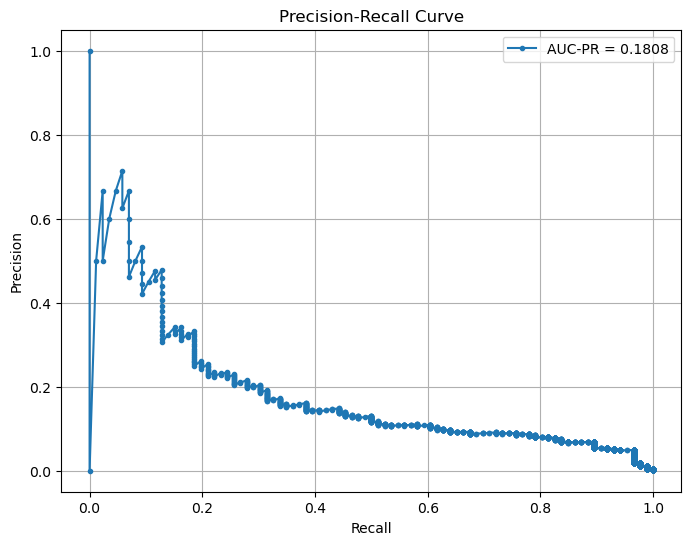

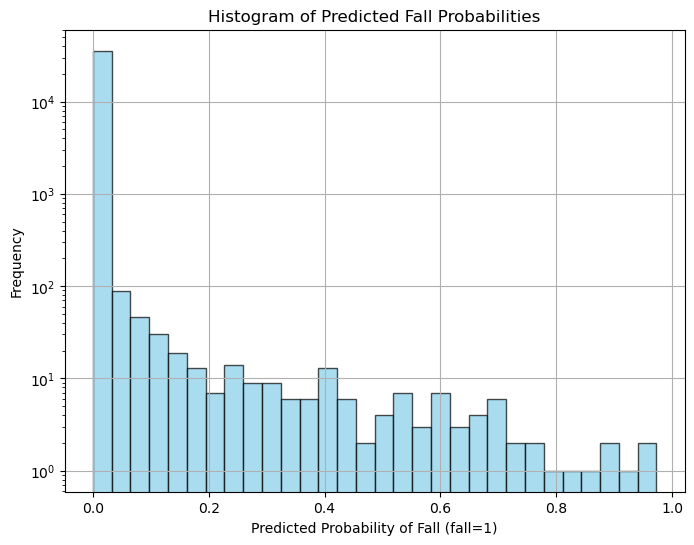

Best Threshold for Precision-Recall Balance: 0.0038


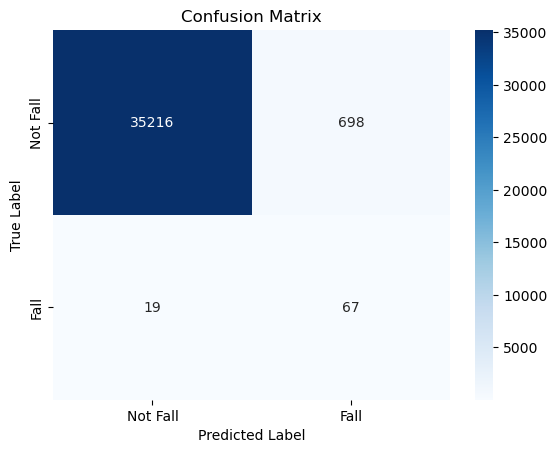

In [74]:
from sklearn.inspection import permutation_importance
from shap import KernelExplainer

# === Step 2: Evaluate on Test Set ===
y_pred_best_classifier = mlp.predict(X_test)
print(np.unique(y_pred_best_classifier, return_counts=True))

print("\nTest set performance with optimized hyperparameters:")
print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
print(classification_report(y_test, y_pred_best_classifier))

# === Step 3: Cross-Validation Prediction for Evaluation ===
cv = StratifiedKFold(n_splits=5)
y_probs = cross_val_predict(mlp, X, y, cv=cv, method="predict_proba")[:, 1]

# === Step 4: Compute AUC-PR and ROC-AUC ===
precision, recall, thresholds = precision_recall_curve(y, y_probs)
auc_pr = auc(recall, precision)
roc_auc = roc_auc_score(y, y_probs)

print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# === Step 5: Plot Precision-Recall Curve ===
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# === Step 6: Histogram of Prediction Probabilities ===
plt.figure(figsize=(8, 6))
plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Predicted Fall Probabilities")
plt.xlabel("Predicted Probability of Fall (fall=1)")
plt.ylabel("Frequency")
plt.yscale('log')  # Apply log scale
plt.grid(True)
plt.show()

# === Step 7: Find Best Threshold for Precision-Recall Tradeoff ===
best_threshold = thresholds[np.argmax(precision * recall)]
print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

# Apply the best threshold
y_pred = (y_probs >= best_threshold).astype(int)

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Logistic Regression

In [43]:
# Get the final pipeline
print(est.fitted_pipeline_)


Pipeline(steps=[('logisticregression', LogisticRegression(C=10.0))])


In [45]:
# Get model predictions on the test set
y_pred_prob = est.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the AUPRC
auprc_score = average_precision_score(y_test, y_pred_prob)

print(f"AUPRC Score: {auprc_score}")

AUPRC Score: 0.25797378110868713


(array([False,  True]), array([7193,    7], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.1765
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.43      0.18      0.25        17

    accuracy                           1.00      7200
   macro avg       0.71      0.59      0.62      7200
weighted avg       1.00      1.00      1.00      7200



c:\Users\felix\anaconda3\envs\tpotenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-PR Score: 0.2363
ROC-AUC Score: 0.9894


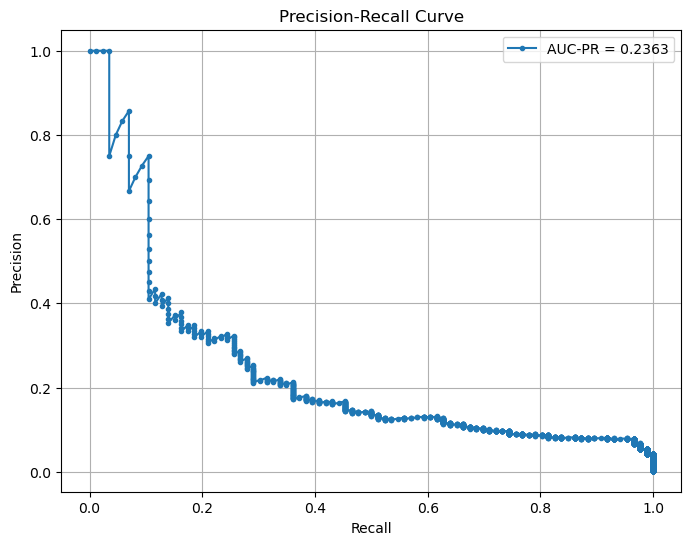

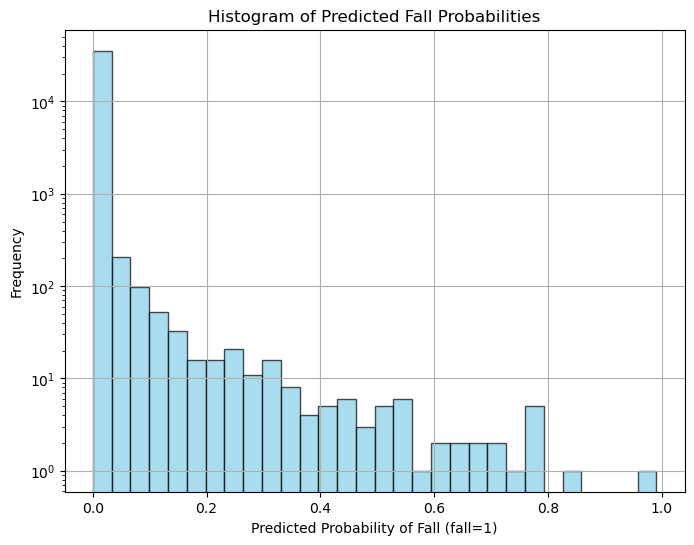

Best Threshold for Precision-Recall Balance: 0.2997


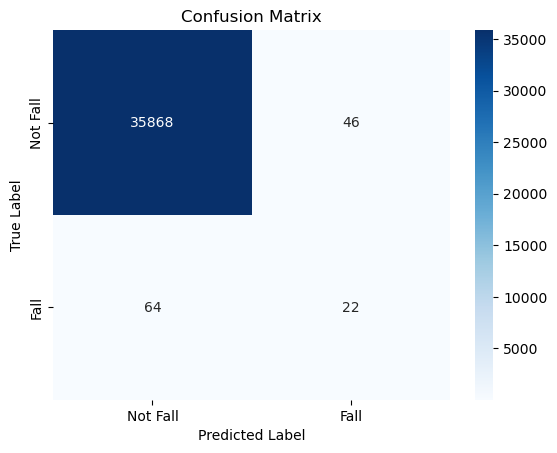

Top 10 Important Features:
                           Feature  Importance
1                       c_zriserh1    0.000472
84         fall-while_stay_Unknown    0.000431
79                      sex_female    0.000264
102    fall-while_transfer_Unknown    0.000250
86        transfer-impairment_True    0.000236
94      cognition-impairment_False    0.000222
118      decubitus-admission_False    0.000194
60                         ICD10_G    0.000167
115  decubitus-at_the_moment_False    0.000167
59                         ICD10_F    0.000139
Shap Values for the train set


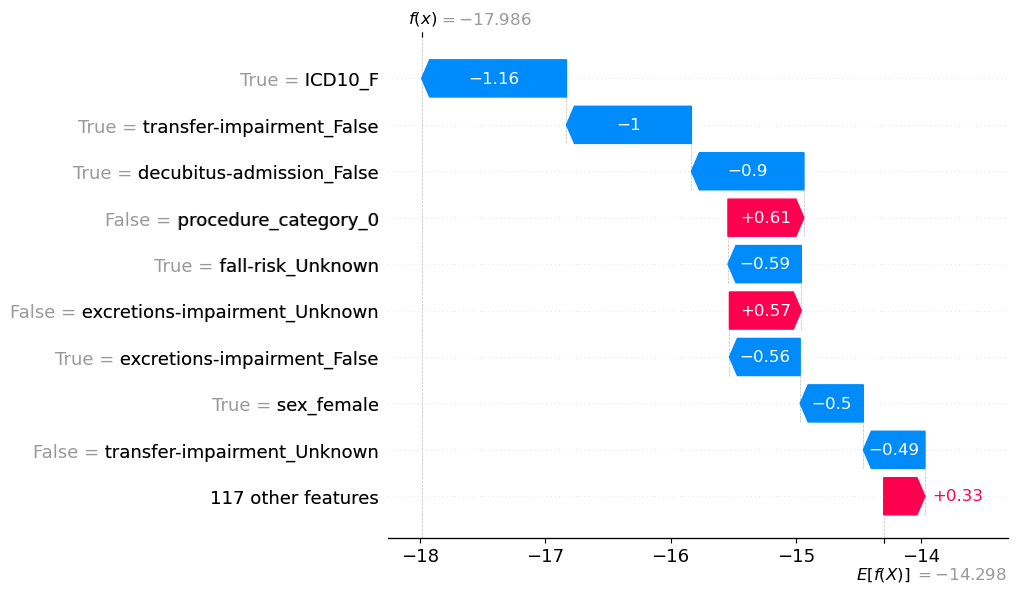

KeyboardInterrupt: 

In [79]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model with C=10.0
logreg_model = LogisticRegression(C=10.0, random_state=42)

# Train the model on the training data
logreg_model.fit(X_train, y_train)

# === Step 2: Evaluate on Test Set ===
y_pred_best_classifier = logreg_model.predict(X_test)
print(np.unique(y_pred_best_classifier, return_counts=True))

print("\nTest set performance with optimized hyperparameters:")
print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
print(classification_report(y_test, y_pred_best_classifier))

# === Step 3: Cross-Validation Prediction for Evaluation ===
cv = StratifiedKFold(n_splits=5)
y_probs = cross_val_predict(logreg_model, X, y, cv=cv, method="predict_proba")[:, 1]

# === Step 4: Compute AUC-PR and ROC-AUC ===
precision, recall, thresholds = precision_recall_curve(y, y_probs)
auc_pr = auc(recall, precision)
roc_auc = roc_auc_score(y, y_probs)

print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# === Step 5: Plot Precision-Recall Curve ===
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# === Step 6: Histogram of Prediction Probabilities ===
plt.figure(figsize=(8, 6))
plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Predicted Fall Probabilities")
plt.xlabel("Predicted Probability of Fall (fall=1)")
plt.ylabel("Frequency")
plt.yscale('log')  # Apply log scale
plt.grid(True)
plt.show()

# === Step 7: Find Best Threshold for Precision-Recall Tradeoff ===
best_threshold = thresholds[np.argmax(precision * recall)]
print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

# Apply the best threshold
y_pred = (y_probs >= best_threshold).astype(int)

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# === Step 9: Feature Importance (Permutation Importance) ===
perm_importance = permutation_importance(logreg_model, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": perm_importance.importances_mean})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print("Top 10 Important Features:")
print(feature_importances.head(10))

print("Shap Values for the train set")
# explainer = shap.KernelExplainer(logreg_model.predict_proba, X_train.sample(100, random_state=42))
# shap_values_train = explainer(X_train)

explainer = shap.Explainer(logreg_model, X_train)
shap_values_train = explainer(X_train)

shap.plots.waterfall(shap_values_train[0])

shap.plots.bar(shap_values_train)
shap.summary_plot(shap_values_train, X_train, plot_type="bar")

shap.plots.beeswarm(shap_values_train)

For some reason computing the SHAP values for the logistic regression takes forever!
The reason for that is that the correct Explainer for the logistic Regression is the KernelEstimator that uses MonteCarlo samples to compute the SHAP values which takes extraordinarily long.
Since XGBoost models were found to also perform significantly well and compute SHAP values much faster with the TreeExplainer it was used to further tune the model.

In [ ]:
train_columns = ["id", "age","walk-balance_and_gait_impaired", "fall-how_many_last_12_month", "excretions-incontinence", "fall-risk_Unknown", "fall-risk_0", "fall-risk_+", "fall-risk_++", "fall-while_stay_False","fall-while_stay_True", "fall-while_stay_Unknown", "transfer-impairment_False", "transfer-impairment_Unknown", "transfer-impairment_True","bed_mobility-impairment_False", "bed_mobility-impairment_True", "bed_mobility-impairment_Unknown", "fall-how_many_last_12_month_missing", "fallen"] 
df1 = df[train_columns]


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation recall: 0.1462
(array([0, 1]), array([7195,    5], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.1176
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.40      0.12      0.18        17

    accuracy                           1.00      7200
   macro avg       0.70      0.56      0.59      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.2162
ROC-AUC Score: 0.9908


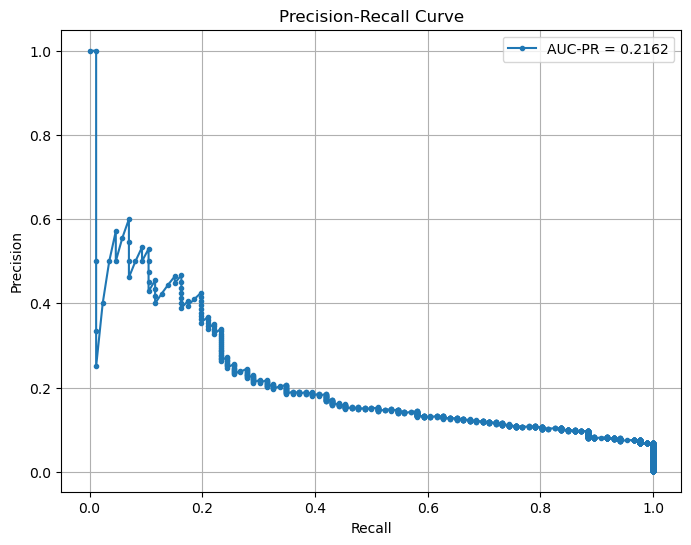

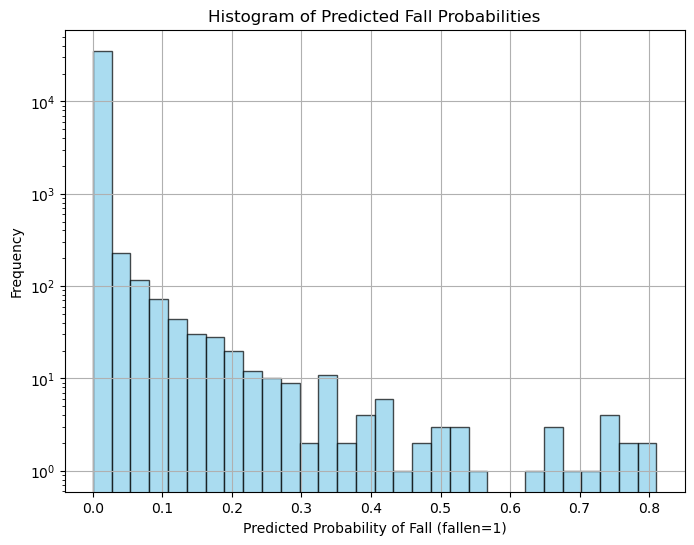

Best Threshold for Precision-Recall Balance: 0.0221


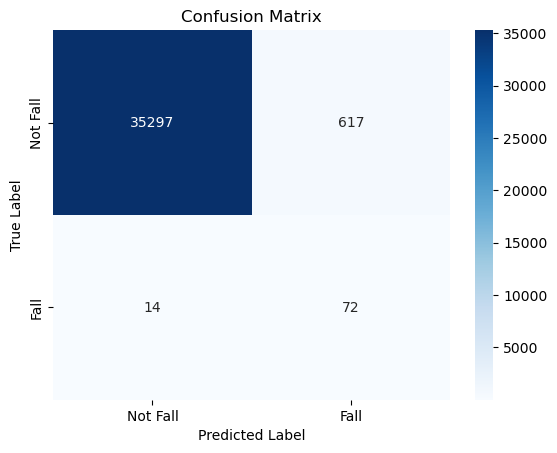

Top 10 Important Features:
                             Feature  Importance
11    walk-balance_and_gait_impaired    0.196124
83              fall-while_stay_True    0.081559
42                       fall-risk_+    0.035871
89      bed_mobility-impairment_True    0.026141
39                 decubitus-risk_++    0.021644
109              medical_items_False    0.019573
101         fall-while_transfer_True    0.019446
60                           ICD10_G    0.017106
37                walk-jones_Unknown    0.016528
98              walk-impairment_True    0.016152
31        bed_mobility-jones_Unknown    0.015737
13           excretions-incontinence    0.014413
52              procedure_category_9    0.014184
110               medical_items_True    0.013816
34                      walk-jones_3    0.012928
1                         c_zriserh1    0.012732
32                      walk-jones_1    0.012252
14               excretions-nykturie    0.012133
48              procedure_category_3    0.

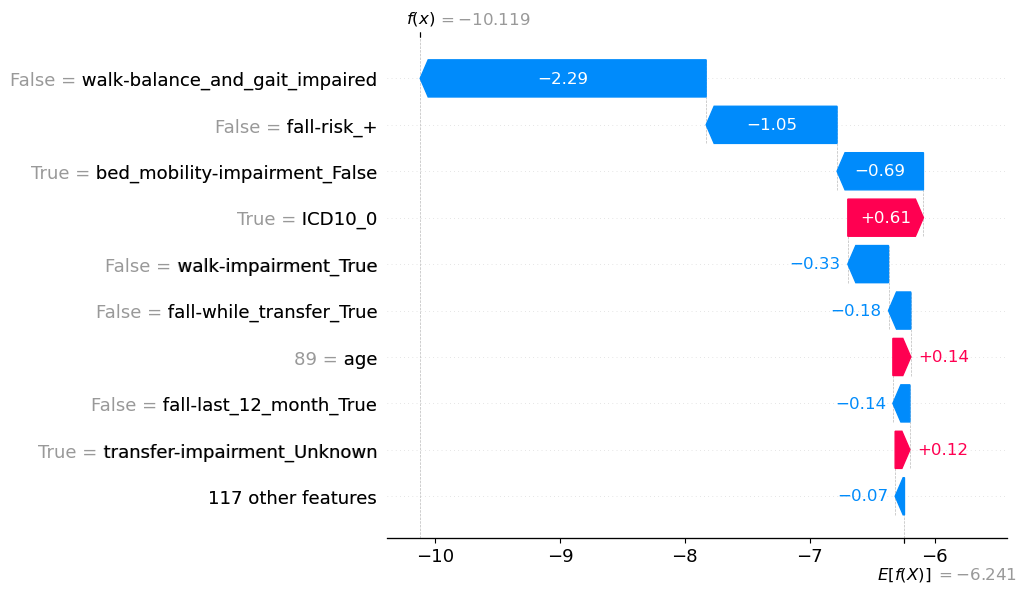

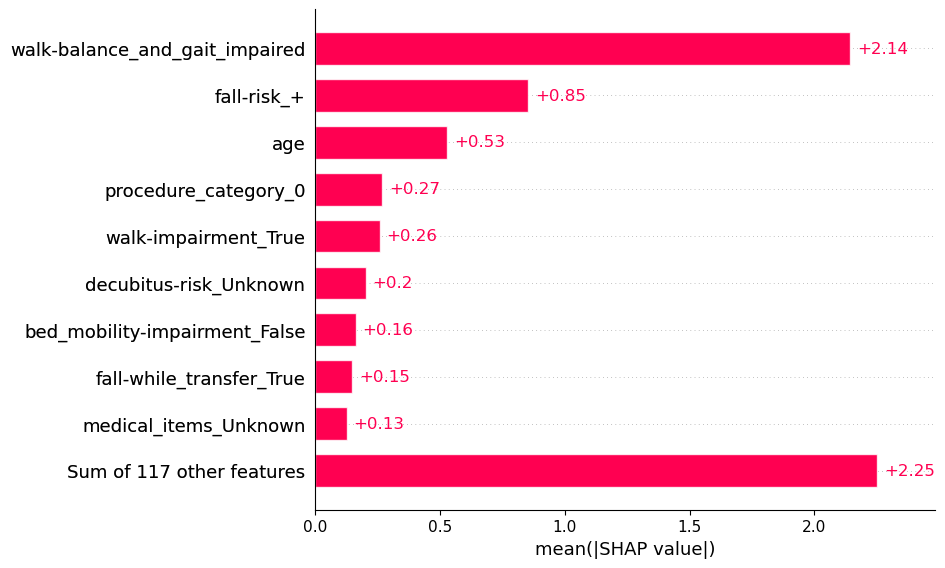

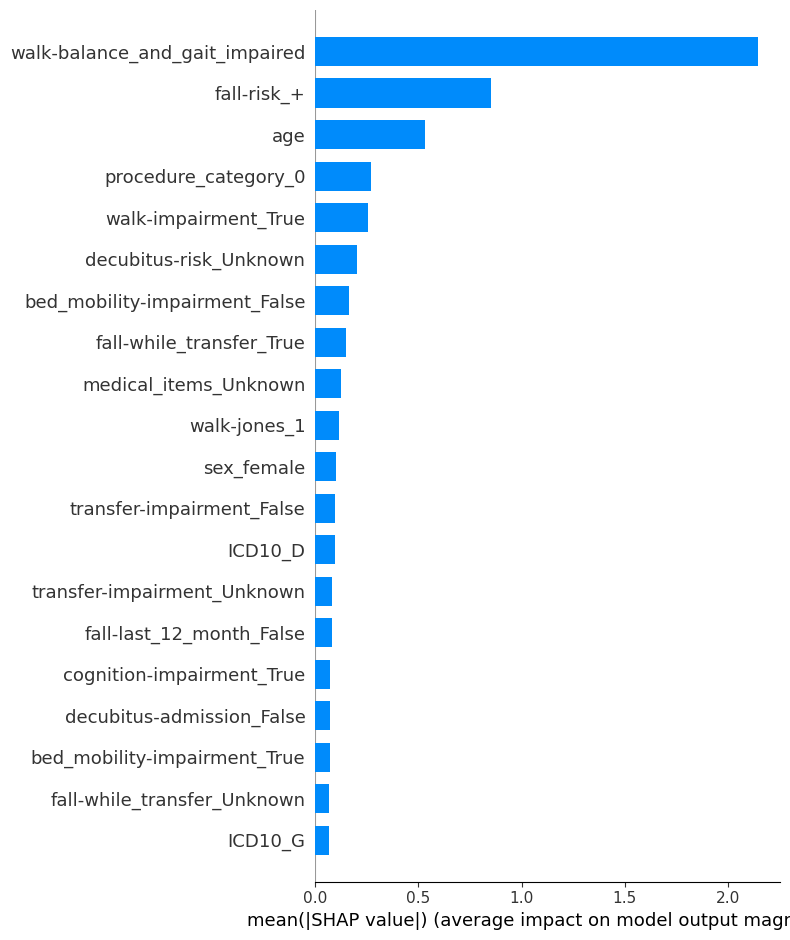

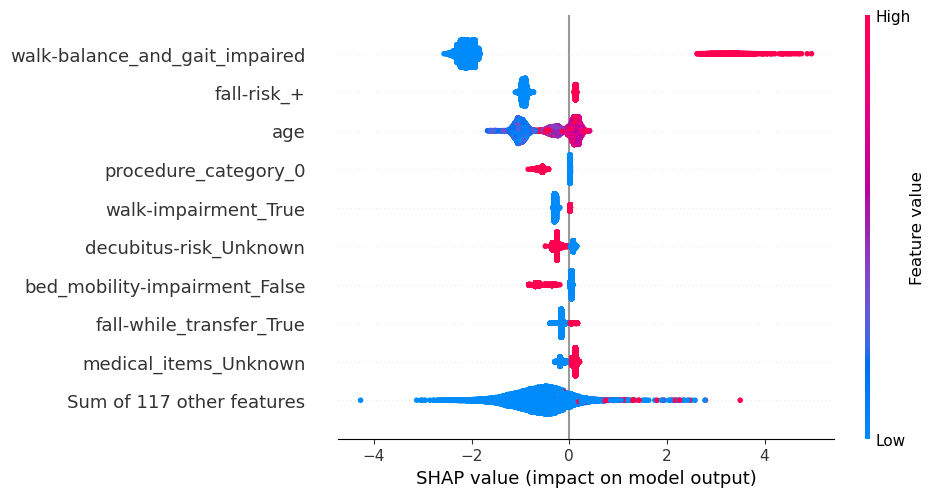

Shap Values for the test set


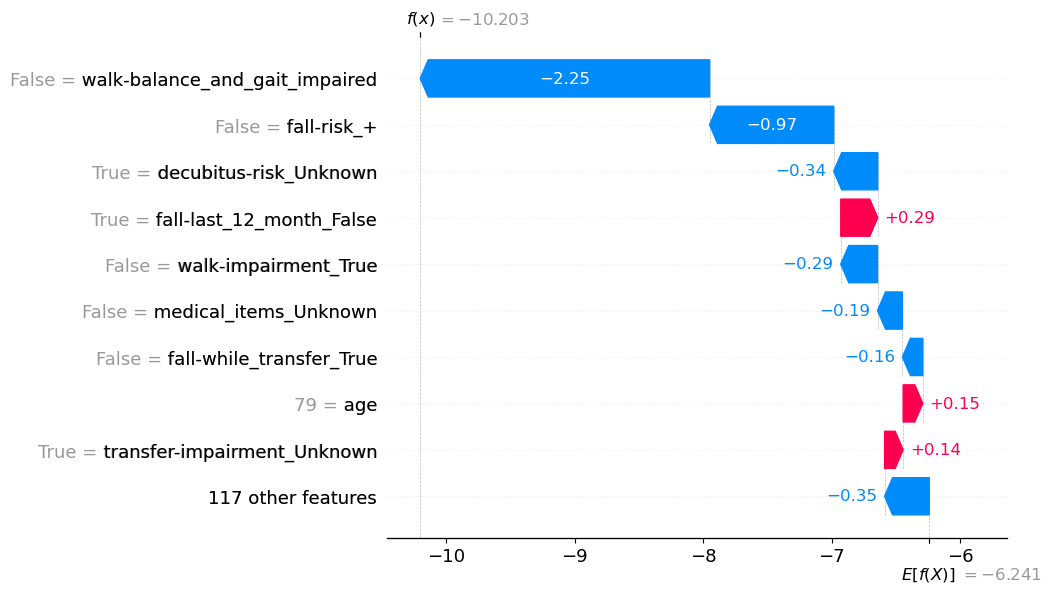

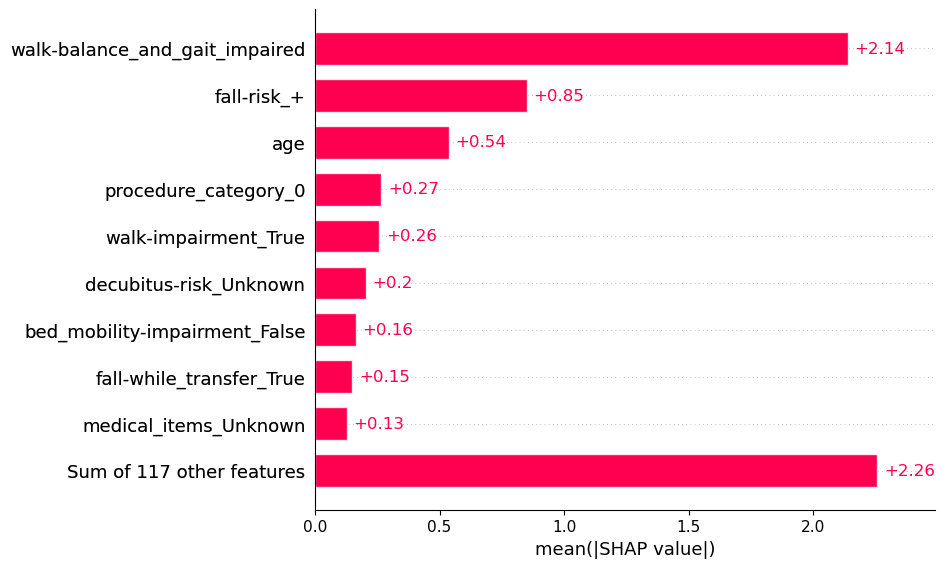

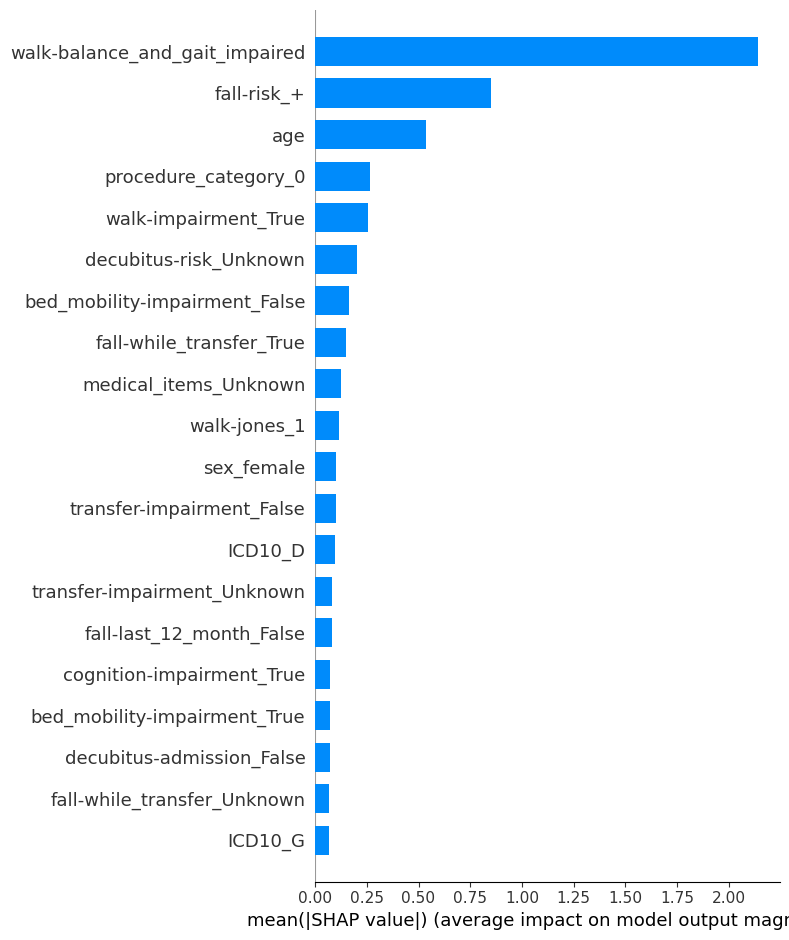

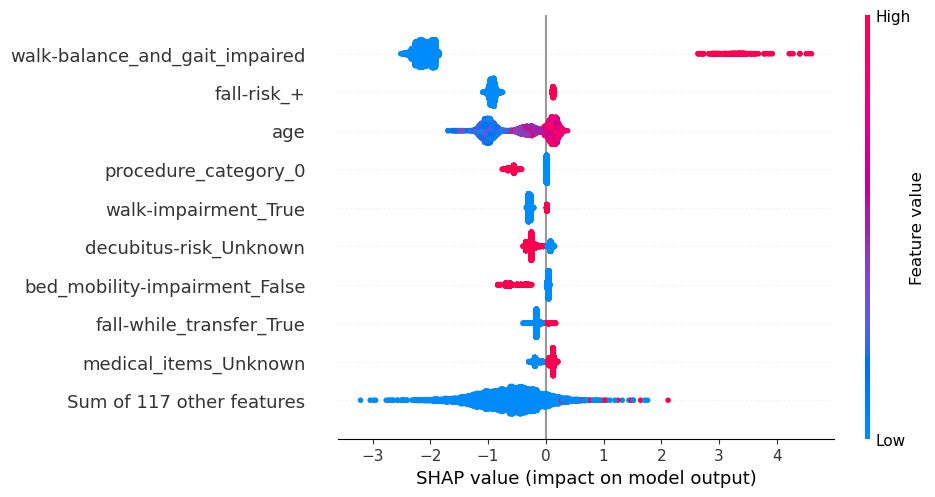

In [84]:
xgb_pipeline(df)

In [83]:

def xgb_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """

    
    # === Load Data ===
    X = df.drop(columns=["fallen", "id", "procedure", "diagnosis", "ICD10_category", "procedure_category"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    # === Step 1: Define Model & Parameter Grid ===
    model = xgb.XGBClassifier()

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(model, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_classifier = grid_search.best_estimator_

    # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # Train a model with the best parameters
    best_classifier.fit(X_train, y_train)

    # Evaluate on test set
    y_pred_best_classifier = best_classifier.predict(X_test)
    print(np.unique(y_pred_best_classifier, return_counts=True))

    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
    print(classification_report(y_test, y_pred_best_classifier))


    # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_classifier, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)
    roc_auc = roc_auc_score(y, y_probs)

    print(f"AUC-PR Score: {auc_pr:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_classifier.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

    print("Shap Values for the train set")
    explainer = shap.TreeExplainer(best_classifier)
    shap_values_train = explainer(X_train)

    shap.plots.waterfall(shap_values_train[0])

    shap.plots.bar(shap_values_train)
    shap.summary_plot(shap_values_train, X_train, plot_type="bar")

    shap.plots.beeswarm(shap_values_train)

    print("Shap Values for the test set")
    shap_values_test = explainer(X_test)
    shap.plots.waterfall(shap_values_test[0])

    shap.plots.bar(shap_values_test)
    shap.summary_plot(shap_values_test, X_test, plot_type="bar")

    shap.plots.beeswarm(shap_values_test)

    # print("Summary of One-Hot Variables")
    # shap_df = pd.DataFrame(shap_values_test.values, columns=X_test.columns)
    # shap.summary_plot(shap_values_test, X_test, plot_type="bar")

    # # Group SHAP values by original categorical feature
    # category_columns = ["fall-risk_0", "fall-risk_+", "fall-risk_++"]
    # # Aggregate SHAP values for the original feature
    # shap_df["fall-risk_SHAP"] = shap_df[category_columns].sum(axis=1)

    # plt.figure(figsize=(6, 4))
    # sns.boxplot(y=shap_df["fall-risk_SHAP"])
    # plt.ylabel("SHAP Value")
    # plt.title("Distribution of Aggregated SHAP Values for Fall Risk")
    # plt.show()
            

## Forward Selection

In [90]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import average_precision_score
from sklearn.base import BaseEstimator

# Assuming you already have X (features) and y (target)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up the SequentialFeatureSelector with forward selection
selector = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select=10,
    direction='forward',  # Forward selection
    scoring='average_precision',  # AUPRC scoring
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1             # Use all CPUs
)

# Fit the feature selector on the training data
selector.fit(X_train, y_train)

# Get the selected features
selected_features = selector.get_support(indices=True)
print(f"Selected feature indices: {selected_features}")


Selected feature indices: [ 11  13  17  25  34  37  66  83  89 104]


In [91]:
X_train_selected = X_train.iloc[:, selected_features]
X_train_selected

,walk-balance_and_gait_impaired,excretions-incontinence,cognition-disoriented_own_person,transfer_Unknown,walk-jones_3,walk-jones_Unknown,ICD10_M,fall-while_stay_True,bed_mobility-impairment_True,fall-last_12_month_True
32155,False,False,False,True,False,True,False,False,False,False
10279,False,False,False,False,False,True,False,False,False,False
26502,False,False,False,True,False,True,False,False,True,False
25647,False,False,False,True,False,False,False,False,False,False
12167,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6279,False,False,False,True,False,True,False,False,False,False
18903,False,False,False,True,False,True,False,False,False,False
35959,False,False,False,True,False,True,False,False,False,False
32923,False,False,False,True,False,False,False,False,False,False


In [92]:
X_val_selected = X_val.iloc[:, selected_features]
X_val_selected

,walk-balance_and_gait_impaired,excretions-incontinence,cognition-disoriented_own_person,transfer_Unknown,walk-jones_3,walk-jones_Unknown,ICD10_M,fall-while_stay_True,bed_mobility-impairment_True,fall-last_12_month_True
26094,False,False,False,True,False,True,False,False,False,False
24122,False,False,False,True,False,True,False,False,False,False
21222,False,False,False,True,False,True,False,False,False,False
5632,False,False,False,True,False,True,True,False,True,False
8332,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
34508,False,False,False,True,False,True,False,False,False,False
22789,False,False,False,True,False,True,True,False,False,False
38704,False,False,False,True,False,True,False,False,False,False
22361,False,False,False,True,False,True,False,False,False,False


In [107]:
train_columns = ["walk-balance_and_gait_impaired", "excretions-incontinence", "transfer_Unknown", "walk-jones_3", "walk-jones_Unknown", "ICD10_M", "fall-while_stay_True", "bed_mobility-impairment_True", "fall-last_12_month_True", "fallen"]
df1 = df[train_columns]

In [ ]:

def xgb_m_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """

    
    # === Load Data ===
    X = df.drop(columns=["fallen"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    # === Step 1: Define Model & Parameter Grid ===
    model = xgb.XGBClassifier()

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(model, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_classifier = grid_search.best_estimator_

    # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # Train a model with the best parameters
    best_classifier.fit(X_train, y_train)

    # Evaluate on test set
    y_pred_best_classifier = best_classifier.predict(X_test)
    print(np.unique(y_pred_best_classifier, return_counts=True))

    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
    print(classification_report(y_test, y_pred_best_classifier))


    # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_classifier, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)
    roc_auc = roc_auc_score(y, y_probs)

    print(f"AUC-PR Score: {auc_pr:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_classifier.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

    print("Shap Values for the train set")
    explainer = shap.TreeExplainer(best_classifier)
    shap_values_train = explainer(X_train)

    shap.plots.waterfall(shap_values_train[0])

    shap.plots.bar(shap_values_train)
    shap.summary_plot(shap_values_train, X_train, plot_type="bar")

    shap.plots.beeswarm(shap_values_train)

    print("Shap Values for the test set")
    shap_values_test = explainer(X_test)
    shap.plots.waterfall(shap_values_test[0])

    shap.plots.bar(shap_values_test)
    shap.summary_plot(shap_values_test, X_test, plot_type="bar")

    shap.plots.beeswarm(shap_values_test)

            


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation recall: 0.1297
(array([0, 1]), array([7198,    2], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.0588
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.50      0.06      0.11        17

    accuracy                           1.00      7200
   macro avg       0.75      0.53      0.55      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.2850
ROC-AUC Score: 0.9905


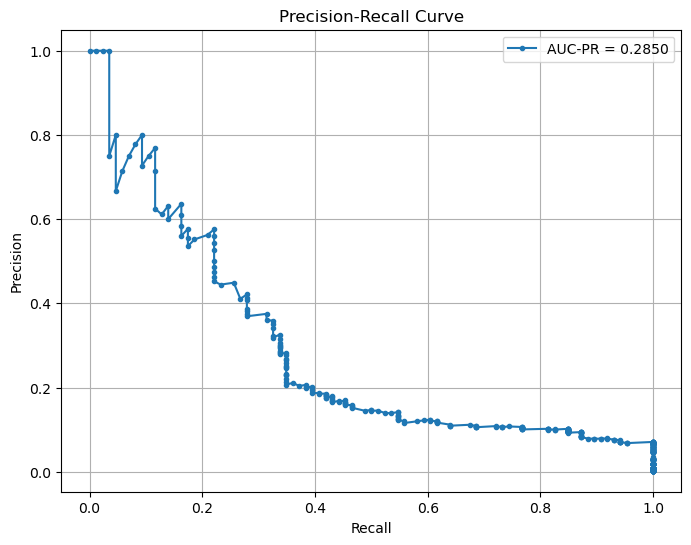

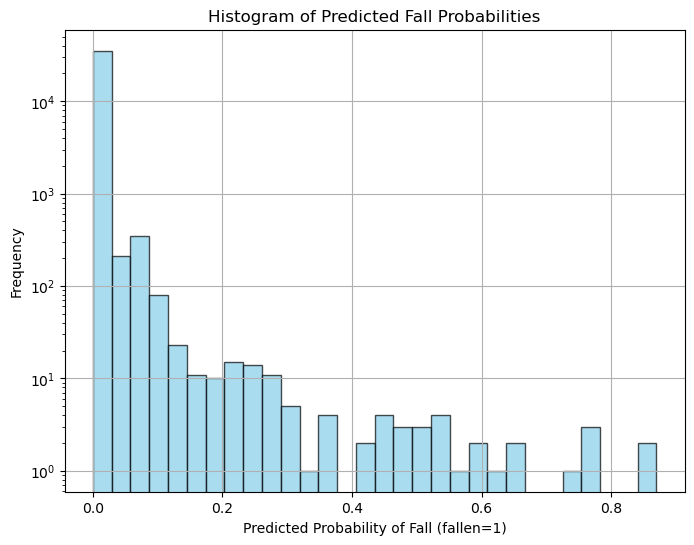

Best Threshold for Precision-Recall Balance: 0.3299


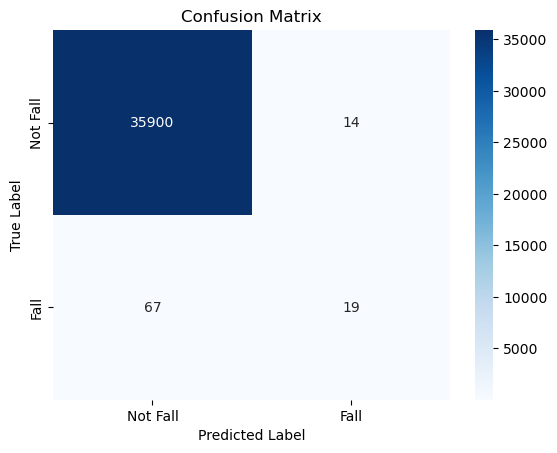

Top 10 Important Features:
                          Feature  Importance
0  walk-balance_and_gait_impaired    0.686759
6            fall-while_stay_True    0.152855
7    bed_mobility-impairment_True    0.033297
1         excretions-incontinence    0.030643
8         fall-last_12_month_True    0.030459
2                transfer_Unknown    0.026075
5                         ICD10_M    0.018895
4              walk-jones_Unknown    0.016478
3                    walk-jones_3    0.004539
Shap Values for the train set


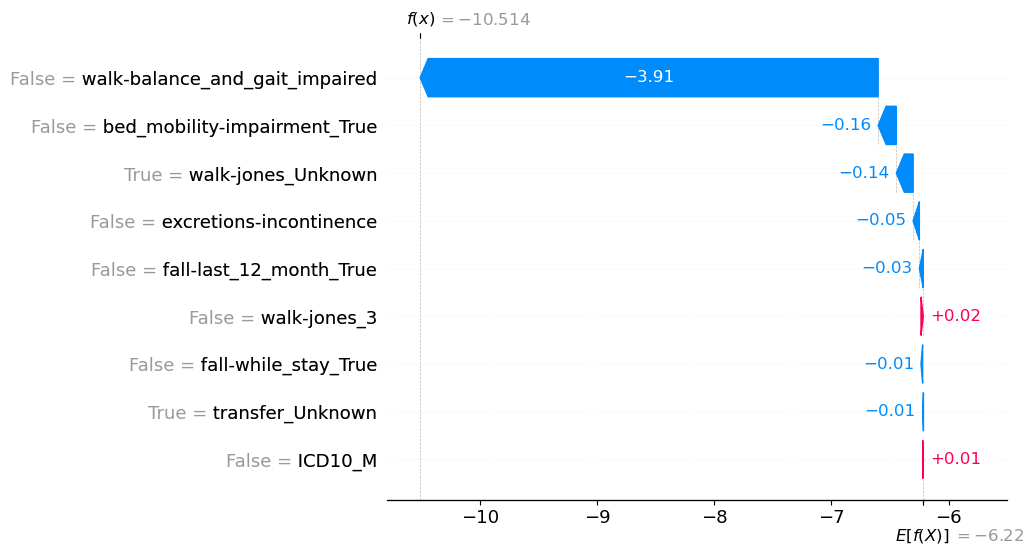

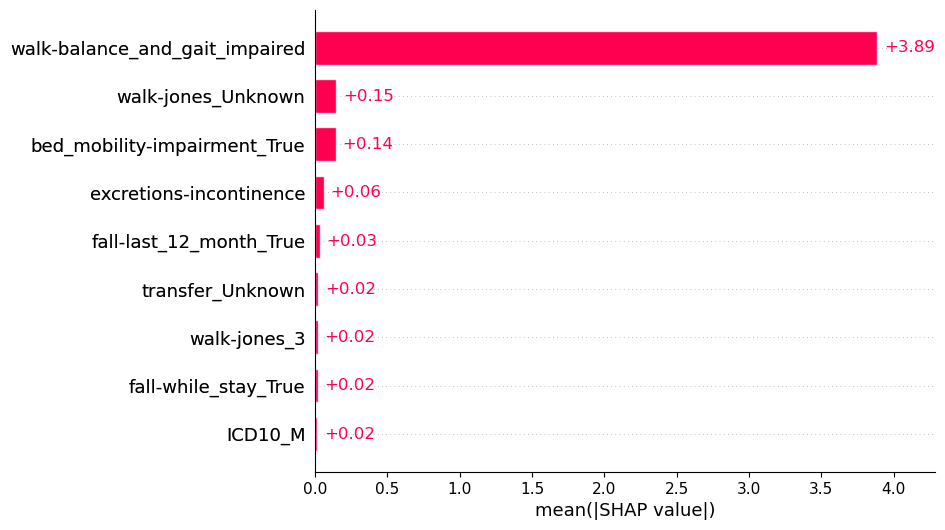

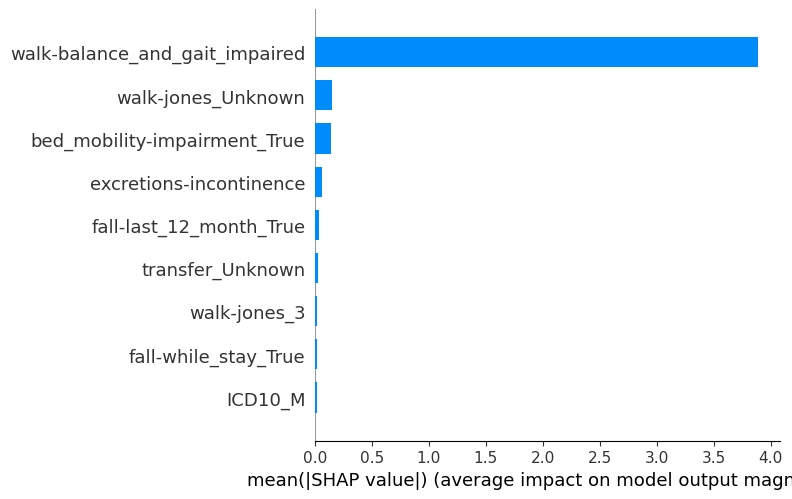

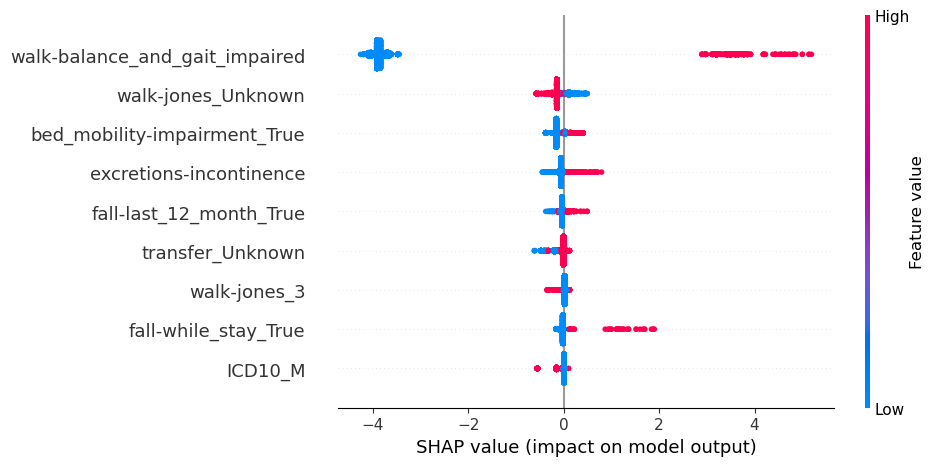

Shap Values for the test set


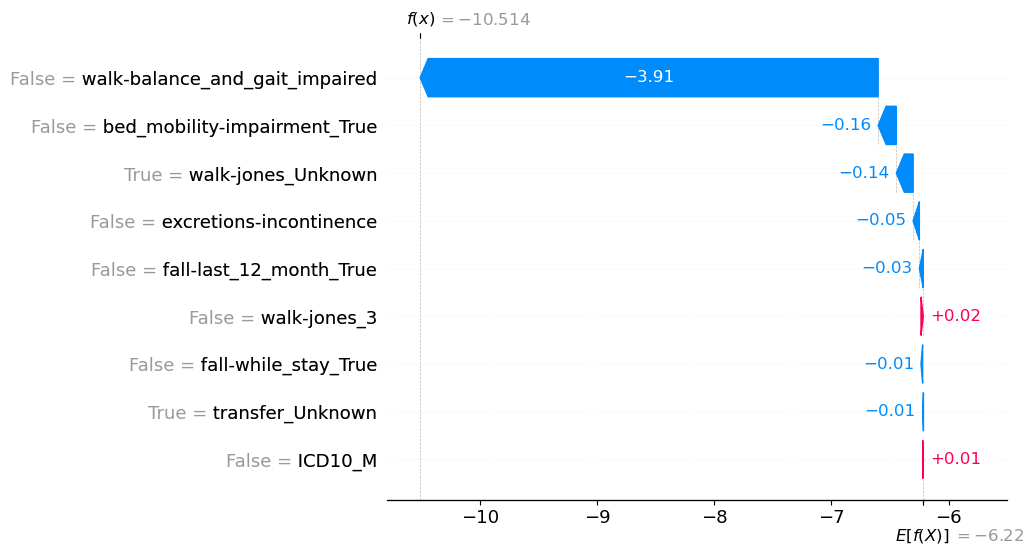

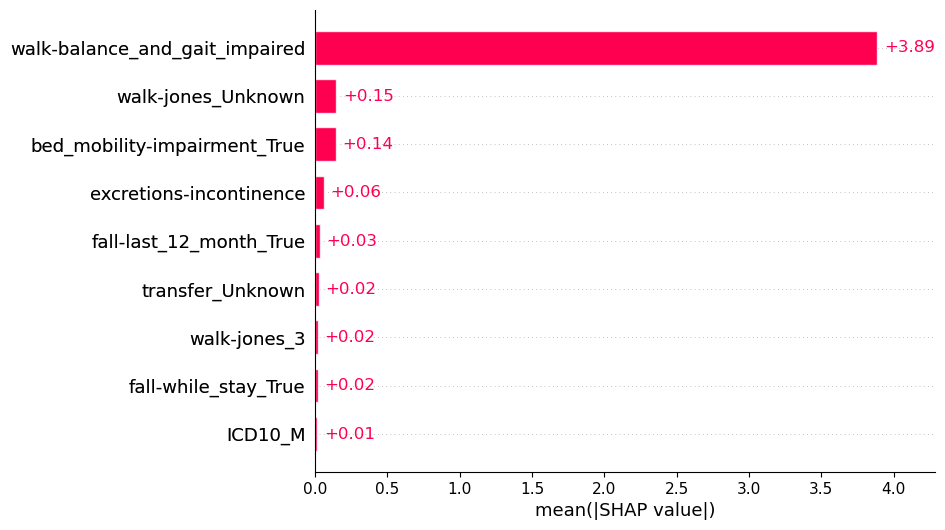

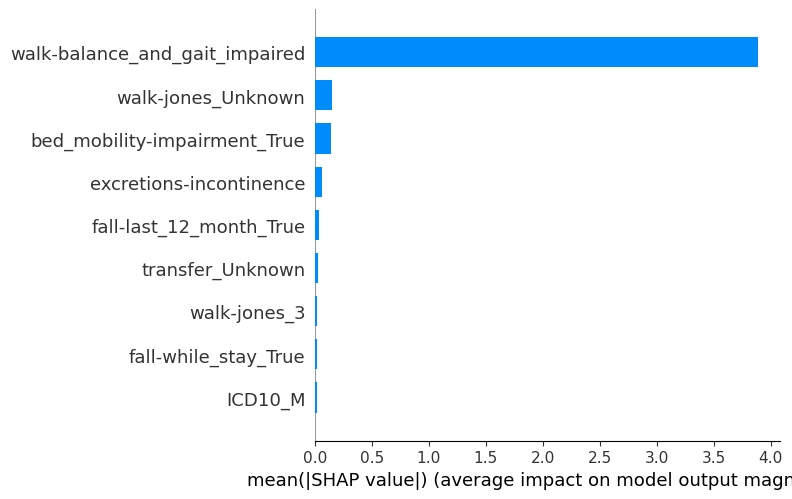

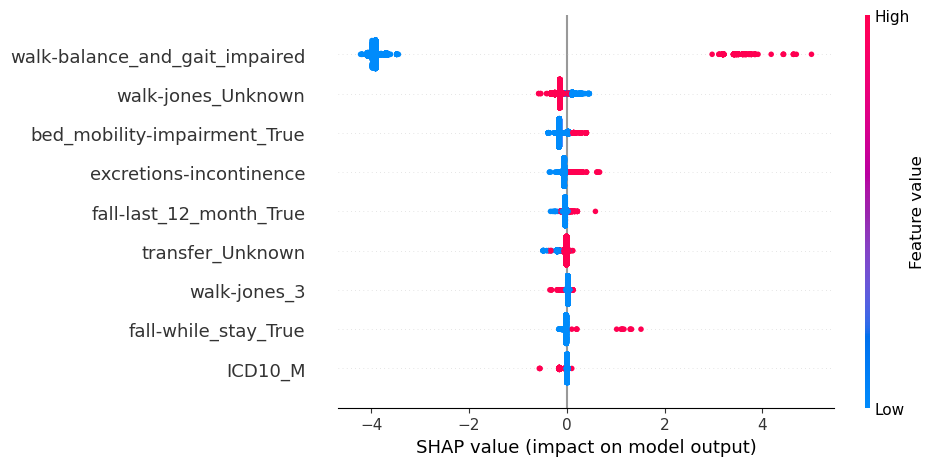

In [108]:
xgb_m_pipeline(df1)

best model so far

adding age reduces performance again by 0.04

same for fall-risk_+ even though only by 0.01